# Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
## February 2024

In [16]:
import warnings

# Packages needed generally
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import xshape
import geopandas as gpd

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs
import dask

### Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as 

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files. 

Things to note:
- The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".

In [17]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables

In [18]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [19]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"], 
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [20]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])


In [21]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)

grid

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60)
Coordinates: (12/63)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
    vonkar                float64 ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg
Data variables:
    *empty*

In [22]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]

In [23]:
# Combine the datasets
combined_dataset = xr.merge([grid, ds_20C])

combined_dataset

ds_20C

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

In [24]:
ds_20C_mean=ds_20C.mean(dim="member_id")

In [25]:
ds_20C.sel(time=slice("1950", "2000"))

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 612, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(612, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

<Axes: >

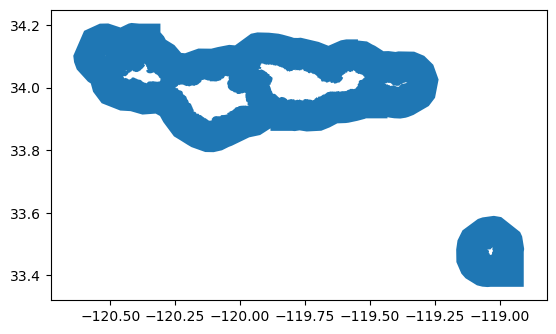

In [26]:
cinms = 'cinms_py'

# Read the shapefile
cinms_shape = gpd.read_file(cinms)

cinms_shape.plot()

In [28]:
# # Create a new figure with Cartopy projection
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# # Plot ocean temperature data
# ds_temp = ds_20C_mean['TEMP'].sel(time='1950-03')
# im = ax.imshow(ds_20C_mean, cmap='coolwarm', origin='lower', extent=[ds_20C_mean.nlon.min(), ds_20C_mean.nlon.max(), ds_20C_mean.nlat.min(),ds_20C_mean.nlat.max()], transform=ccrs.PlateCarree())

# # Overlay shapefile
# cinms_shape.plot(ax=ax, color='none', edgecolor='black', transform=ccrs.PlateCarree())

# # Customize the plot
# ax.set_title('Ocean Temperature (20C Experiment)')
# ax.coastlines()
# plt.colorbar(im, ax=ax, label='Temperature')
# plt.show()

In [30]:
# Define the coordinates for the Channel Islands National Marine Sanctuary
sanctuary_lat_min = 33.36241
sanctuary_lat_max = 34.20492
sanctuary_lon_min = -120.64208
sanctuary_lon_max = -118.90712


### Example 2: CMIP6

Now I'll do the same thing for the multi-model CMIP6 database, following procedures similar to

https://github.com/pangeo-data/pangeo-cmip6-examples/blob/master/basic_search_and_load.ipynb

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

In [ ]:
# Locate monthly sea surface temperature (tos) from all simulations of the historical period
df_ta = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'historical'")
df_ta

In [ ]:
# Get only information for a specific model: say, CanESM5
df_ta_canesm5 = df_ta.query('source_id == "CanESM5"')
df_ta_canesm5

In [ ]:
# create login credentials, for accessing file system anonymously: this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

In [ ]:
# get all paths to the relevant datasets
zstore = df_ta_canesm5.zstore

# display them
zstore

In [ ]:
# Test data I/O by using the first entry in the data table
zstore = df_ta_canesm5.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds


# taking a look at the physical coordinates
#print(ds.latitude.attrs)
#print(ds.longitude.attrs)

In [ ]:
#examine the coord variables by plotting them 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
ds.latitude.plot(ax=ax1)
ds.longitude.plot(ax=ax2)

In [ ]:
import cartopy.crs as ccrs

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.tos[200].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="i", y="j"
)
ax.coastlines()
ax.set_ylim([0, 90])

In [ ]:
#for 1950
#ds.tos.sel(time='1950-03').squeeze().plot()

# Define latitude and longitude ranges for Southern California coast
lat_range = slice(100, 200)  # just guessing the cell indexing 
lon_range = slice(200, 300)  #just guessing the cell indexing 

# Subset the dataset
subset = ds.sel(i=lat_range, j=lon_range)

subset.tos.sel(time='1950-03').squeeze().plot()

#ds_2000 = ds.latitude.tos.sel(time='2000-03')

In [ ]:
ds1 = ds.tos.sel(time='1950-03')

## Maybe what we can do is pull a shape file and read the coordinates through here. 

I found this one on NOAA.

In [ ]:
import geopandas as gpd

# Replace 'your_shapefile.shp' with the path to your shapefile
cinms = 'cinms_py'

# Read the shapefile
cinms_shape = gpd.read_file(cinms).to_crs(4326)

cinms_shape.plot()

In [ ]:
import cartopy.crs as ccrs
import xshape

# Create a plot
fig, ax = plt.subplots(figsize=(30,30), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the Xarray dataset as background
ds1.plot(ax=ax, # using for ds1
         transform=ccrs.PlateCarree(),
            cbar_kwargs={'shrink': 0.5})

# Set the extent of the plot based on the shapefile bounding box
ax.set_extent([cinms_shape.total_bounds[0], cinms_shape.total_bounds[2], cinms_shape.total_bounds[1], cinms_shape.total_bounds[3]])

# Plot the shapefile
cinms_shape.plot(ax=ax)

# Add gridlines
ax.gridlines(draw_labels=True)

# Add a title
ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature- March 1950')

# Show the plot
plt.show()

# Shift longitude from 0,360 to -180,180

In [ ]:
ds.coords['longitude'] = (ds['longitude'] + 180) % 360 - 180
ds.coords['latitude'] = (ds['latitude'] + 90) % 180 - 90

In [ ]:
ds['tos'].latitude.values.min(), ds['tos'].latitude.values.max()

In [ ]:
ds['tos'].longitude.values.min(), ds['tos'].longitude.values.max()

In [ ]:
# Filter the dataset based on Southern California coordinates
dset_selection = ds.where(
    (ds.latitude > 32) & (ds.latitude < 34) &
    (ds.longitude > -118) & (ds.longitude < -114)
)
dset_selection